<a href="https://colab.research.google.com/github/Ashwin1234/CS-521-Project/blob/master/CS521Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from gensim.utils import tokenize
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

In [4]:
dataset = load_dataset("liar")

Using custom data configuration default


Generating train split:   0%|          | 0/10269 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1283 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1284 [00:00<?, ? examples/s]

Dataset liar downloaded and prepared to /root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
dataset_train = pd.DataFrame(dataset['train'])
dataset_test = pd.DataFrame(dataset['test'])
dataset_validate = pd.DataFrame(dataset['validation'])

In [6]:
dataset_train.size

143766

In [7]:
dataset_train.describe()

,label,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts
count,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000
mean,2.136722,11.560132,13.313857,17.195637,16.490505,6.202746
std,1.585507,19.006447,24.140583,35.948211,36.251253,16.117701
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,2.000000,3.000000,3.000000,1.000000
75%,3.000000,12.000000,15.000000,13.000000,11.000000,5.000000
max,5.000000,70.000000,114.000000,160.000000,163.000000,105.000000


In [8]:
dataset_train.head()

,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635.json,0,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,2,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,0,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,1,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


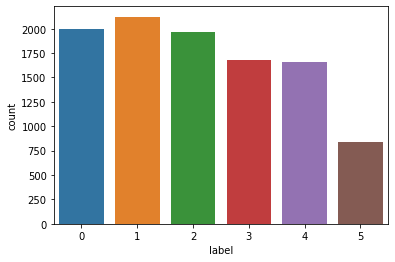

In [9]:
sns.countplot(x = 'label', data = dataset_train)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 99.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 99.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 99.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 91.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 87.9% of the points cannot be placed; y

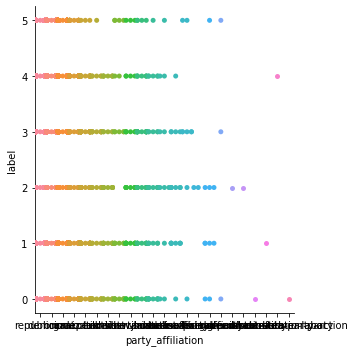

In [10]:
sns.catplot(x='party_affiliation', y='label', kind = 'swarm', data = dataset_train)

In [ ]:

dataset_train['statement'] = dataset_train.apply(lambda row : row['statement'].lower(), axis = 1)


In [ ]:
# Removing stop words
dataset_train['statement'] = dataset_train.apply(lambda row: remove_stopwords(row['statement']),axis = 1)

In [ ]:
#Tokenization

dataset_train['statement'] = dataset_train.apply(lambda row : list(tokenize(row['statement'])), axis = 1)

In [ ]:
#Lemmatization
lemmatizer = WordNetLemmatizer()
dataset_train['comment'] = dataset_train.apply(lambda row : list(lemmatizer.lemmatize(word) for word in row['statement']),axis = 1)

In [ ]:

dataset_train['statement']

0        [says, annies, list, political, group, support...
1        [decline, coal, start, started, natural, gas, ...
2        [hillary, clinton, agrees, john, mccain, by, v...
3        [health, care, reform, legislation, likely, ma...
4               [economic, turnaround, started, end, term]
                               ...                        
10264    [larger, number, shark, attacks, florida, case...
10265     [democrats, party, atlanta, metro, area, blacks]
10266    [says, alternative, social, security, operates...
10267    [lifting, u, s, cuban, embargo, allowing, trav...
10268    [department, veterans, affairs, manual, tellin...
Name: statement, Length: 10269, dtype: object

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [2]:
!pip install datasets

     |████████████████████████████████| 325 kB 8.0 MB/s 
     |████████████████████████████████| 212 kB 42.1 MB/s 
     |████████████████████████████████| 1.1 MB 39.4 MB/s 
     |████████████████████████████████| 136 kB 44.0 MB/s 
     |████████████████████████████████| 77 kB 2.7 MB/s 
     |████████████████████████████████| 127 kB 45.5 MB/s 
     |████████████████████████████████| 271 kB 34.6 MB/s 
     |████████████████████████████████| 144 kB 50.1 MB/s 
     |████████████████████████████████| 94 kB 1.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [14]:
x_train = dataset_train['statement']
y_train = dataset_train['label']

In [15]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit(x_train)
freq_term_matrix = count_vectorizer.transform(x_train)
tfidf = TfidfTransformer(norm = "l2")
tfidf.fit(freq_term_matrix)
tf_idf_matrix = tfidf.fit_transform(freq_term_matrix)

In [22]:
x_train,x_test,y_train,y_test = train_test_split(tf_idf_matrix,y_train,test_size = 0.3)

In [19]:
lr = LogisticRegression()

In [23]:
lr.fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [24]:
lr.score(x_test,y_test)

0.2310938007140539

In [29]:
mnb = MultinomialNB()

In [30]:
mnb.fit(x_train,y_train)

MultinomialNB()

In [31]:
mnb.score(x_test,y_test)

0.2317429406037001

In [34]:
rfc = RandomForestClassifier()

In [35]:
rfc.fit(x_train,y_train)

RandomForestClassifier()

In [36]:
rfc.score(x_test,y_test)

0.24407659850697824